In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

pd.set_option("display.max_columns", None)

print('success')

success


### Processing images
#### Example taken from: https://www.kaggle.com/seyunhan/inceptionresnetv2-keras-pbl4

We load the train,test,val images here

In [13]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
17696,fffb900a92289a33.jpg,[healthy]
17697,fffc488fa4c0e80c.jpg,[scab]
17698,fffc94e092a59086.jpg,[rust]
17699,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2037
frog_eye_leaf_spot    4139
healthy               4396
powdery_mildew        1210
rust                  1963
scab                  5435
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

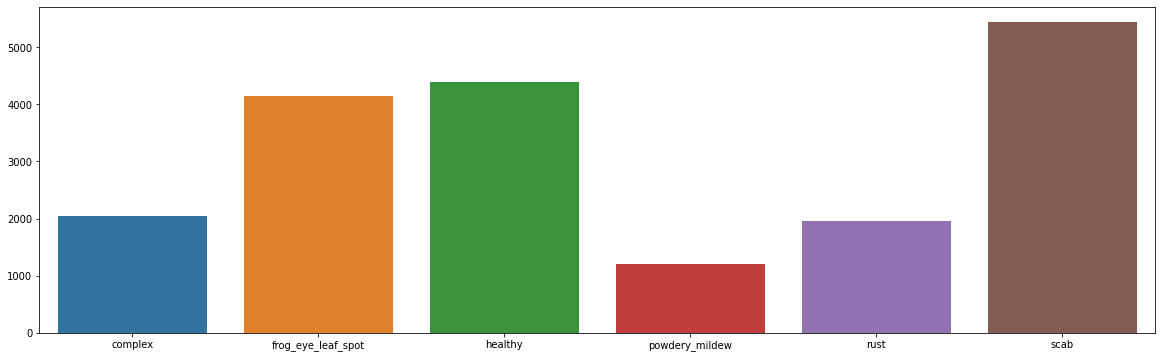

In [4]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

### Viewing some images

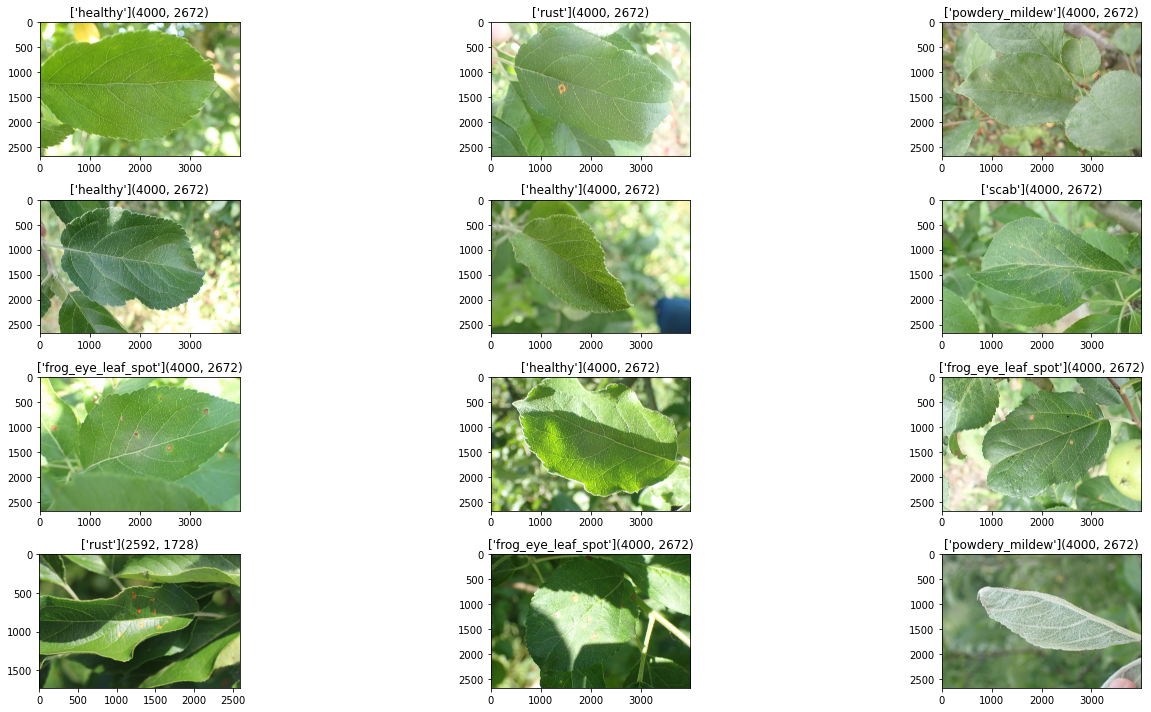

In [5]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('./train_images/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

#'../input/plant-pathology-2021-fgvc8/train_images'
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='./train_images',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

Found 15931 validated image filenames belonging to 6 classes.
Found 1770 validated image filenames belonging to 6 classes.


In [7]:
import h5py

In [8]:
seed = 1200
tf.random.set_seed(seed)

# weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
# model = keras.applications.InceptionResNetV2(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
model = keras.applications.NASNetLarge(input_shape=(331, 331, 3), include_top=False, weights='imagenet', classes=1000)
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 331, 331, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 11, 11, 4032), dtype=tf.float32, name=None), name='activation_259/Relu:0', description="created by layer 'activation_259'")


In [9]:
new_model = tf.keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(6, 
        kernel_initializer=keras.initializers.RandomUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])

# Freezing the weights
for layer in new_model.layers[:-1]:
    layer.trainable=False
    
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 global_average_pooling2d (G  (None, 4032)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_top (Dense)           (None, 6)                 24198     
                                                                 
Total params: 84,941,016
Trainable params: 24,198
Non-trainable params: 84,916,818
_________________________________________________________________


In [10]:
## TO use CPU
CUDA_VISIBLE_DEVICES=""
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
print('success')

success


In [11]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

# tf.config.experimental.set_memory_growth(
#     physical_devices[0], enable='True'
# )

# import PIL.Image

Num GPUs Available:  0


In [12]:
from tensorflow.keras.callbacks import EarlyStopping
import PIL
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')

new_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy',f1])
callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=4, mode='max', restore_best_weights=True)
history = new_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=65,
                    steps_per_epoch=train_generator.samples//256, # = 58
                    validation_steps=valid_generator.samples//128,
                    callbacks=callbacks)


C:\Users\riley\AppData\Local\Temp\ipykernel_20532\3583829206.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=train_generator,


Epoch 1/65
62/62 [==============================] - 352s 5s/step - loss: 0.4366 - accuracy: 0.3916 - f1_score: 0.3002 - val_loss: 0.3713 - val_accuracy: 0.5096 - val_f1_score: 0.4428
Epoch 2/65
62/62 [==============================] - 336s 5s/step - loss: 0.3638 - accuracy: 0.5045 - f1_score: 0.4392 - val_loss: 0.3544 - val_accuracy: 0.5168 - val_f1_score: 0.4586
Epoch 3/65
62/62 [==============================] - 331s 5s/step - loss: 0.3418 - accuracy: 0.5504 - f1_score: 0.4991 - val_loss: 0.3197 - val_accuracy: 0.5889 - val_f1_score: 0.5243
Epoch 4/65
62/62 [==============================] - 336s 5s/step - loss: 0.3300 - accuracy: 0.5711 - f1_score: 0.5299 - val_loss: 0.3176 - val_accuracy: 0.6034 - val_f1_score: 0.5725
Epoch 5/65
62/62 [==============================] - 325s 5s/step - loss: 0.3124 - accuracy: 0.6038 - f1_score: 0.5631 - val_loss: 0.3160 - val_accuracy: 0.5962 - val_f1_score: 0.5489
Epoch 6/65
62/62 [==============================] - 325s 5s/step - loss: 0.3131 - acc

In [17]:
for img_name in tqdm(test['image']):
    path = './test_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./test_size256_images/{img_name}')

100%|██████████| 931/931 [01:27<00:00, 10.67it/s]


In [22]:
test_data = datagen.flow_from_dataframe(
    test,
    directory = './test_size256_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (256,256),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = new_model.predict(test_data)
print(preds)
preds = preds.tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.3:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)
    
print(indices)

Found 931 validated image filenames.
[[3.25453222e-01 3.11547577e-01 9.04463232e-02 1.27381980e-02
  1.70397162e-01 2.78822780e-02]
 [9.52970386e-02 3.13880950e-01 2.03315496e-01 2.66820192e-04
  9.94974375e-03 2.26879895e-01]
 [5.15023470e-02 2.68827975e-02 1.55876875e-02 2.31239498e-02
  6.28325343e-03 7.61370361e-01]
 ...
 [4.15179133e-03 5.57188094e-02 5.96397460e-01 4.24653292e-04
  9.12278891e-04 7.30771601e-01]
 [4.44191992e-01 4.83315170e-01 7.08916783e-02 7.67940283e-03
  4.69517410e-02 5.57642281e-02]
 [6.88274384e-01 3.15524042e-01 3.81290913e-04 3.59383225e-03
  1.75798982e-01 5.12881517e-01]]
[[0, 1], [1], [5], [0, 1, 4], [3, 5], [0, 1, 5], [3], [2], [0, 1, 5], [5], [2], [5], [4], [5], [1, 5], [5], [2], [5], [3], [2], [4], [5], [3], [3], [5], [5], [0, 1, 5], [5], [1, 2], [5], [3], [2], [0], [2], [5], [1], [1], [5], [5], [2], [5], [5], [2], [5], [4], [2], [4], [2], [5], [2], [5], [3], [2], [5], [4], [0, 4], [4, 5], [4], [0, 1], [5], [1, 5], [2], [0, 3], [1, 5], [0, 1, 5], [

In [23]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['complex frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'scab', 'complex frog_eye_leaf_spot rust', 'powdery_mildew scab', 'complex frog_eye_leaf_spot scab', 'powdery_mildew', 'healthy', 'complex frog_eye_leaf_spot scab', 'scab', 'healthy', 'scab', 'rust', 'scab', 'frog_eye_leaf_spot scab', 'scab', 'healthy', 'scab', 'powdery_mildew', 'healthy', 'rust', 'scab', 'powdery_mildew', 'powdery_mildew', 'scab', 'scab', 'complex frog_eye_leaf_spot scab', 'scab', 'frog_eye_leaf_spot healthy', 'scab', 'powdery_mildew', 'healthy', 'complex', 'healthy', 'scab', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'scab', 'scab', 'healthy', 'scab', 'scab', 'healthy', 'scab', 'rust', 'healthy', 'rust', 'healthy', 'scab', 'healthy', 'scab', 'powdery_mildew', 'healthy', 'scab', 'rust', 'complex rust', 'rust scab', 'rust', 'complex frog_eye_leaf_spot', 'scab', 'frog_eye_leaf_spot scab', 'healthy', 'complex powdery_milde

In [31]:
actuallabels = list(test['labels'])
print(actuallabels)

['frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'scab', 'frog_eye_leaf_spot', 'powdery_mildew', 'complex', 'powdery_mildew', 'healthy', 'scab', 'complex', 'healthy', 'healthy', 'rust', 'scab', 'complex', 'scab', 'healthy', 'scab', 'powdery_mildew', 'healthy', 'rust', 'frog_eye_leaf_spot', 'powdery_mildew', 'powdery_mildew', 'scab', 'scab', 'frog_eye_leaf_spot', 'scab', 'healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'healthy', 'complex', 'healthy', 'scab', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'scab', 'healthy', 'scab', 'healthy', 'healthy', 'scab', 'rust', 'healthy', 'rust', 'powdery_mildew', 'scab', 'healthy', 'frog_eye_leaf_spot', 'powdery_mildew', 'scab', 'rust', 'rust', 'complex', 'frog_eye_leaf_spot', 'frog_eye_leaf_spot', 'complex', 'scab', 'scab', 'healthy', 'healthy', 'frog_eye_leaf_spot', 'complex', 'scab', 'complex', 'rust', 'healthy', 'complex', 'healthy', 'complex', 'scab', 'rust', 'scab', 'complex', 'frog_eye_leaf_spot', 'scab', 'scab', 'scab', 'powdery_mildew',

In [36]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(actuallabels,testlabels)
print(f"Test accuracy score: {accuracy}")

Test accuracy score: 0.5123523093447906


In [20]:
actual_test = pd.read_csv('sample_submission.csv')

In [34]:
actual_test_data = datagen.flow_from_dataframe(
    actual_test,
    directory = './actual_test_images',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (256,256),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

actual_preds = new_model.predict(actual_test_data)
print(actual_preds)
actual_preds = actual_preds.tolist()

indices = []
for pred in actual_preds:
    temp = []
    for category in pred:
        if category>=0.3:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)
    
print(indices)

Found 3 validated image filenames.
[[7.2029662e-01 2.9084563e-01 9.1618299e-04 6.3170791e-03 1.7512232e-02
  1.5388379e-01]
 [5.2997243e-01 5.2037054e-01 2.9015541e-04 4.2134523e-04 2.7173713e-01
  1.1389509e-01]
 [4.0577197e-01 8.7384510e-01 1.2305081e-03 6.9387078e-02 1.3334781e-02
  4.4005722e-02]]
[[0], [0, 1], [0, 1]]


In [35]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

actualtestlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    actualtestlabels.append(' '.join(temp))

print(actualtestlabels)

{0: 'complex', 1: 'frog_eye_leaf_spot', 2: 'healthy', 3: 'powdery_mildew', 4: 'rust', 5: 'scab'}
['complex', 'complex frog_eye_leaf_spot', 'complex frog_eye_leaf_spot']


In [38]:
sub = pd.read_csv('./sample_submission.csv')
sub['labels'] = actualtestlabels
sub.to_csv('submission.csv', index=False)
sub

,image,labels
0,85f8cb619c66b863.jpg,complex
1,ad8770db05586b59.jpg,complex frog_eye_leaf_spot
2,c7b03e718489f3ca.jpg,complex frog_eye_leaf_spot
